In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
%cd /content/drive/MyDrive/Colab Notebooks/geiot

/content/drive/.shortcut-targets-by-id/1HvjC1Sh_DFmMvqXUWGoYm1lsmbFoWO8K/Colab Notebooks/geiot


In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from tqdm import tqdm
from torchvision import models,transforms
from PIL import Image
import cv2
import sys
import json
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import os
import os.path as osp
from glob import glob
import pandas as pd

In [97]:
test_dataset=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/geiot/input/test/test_anno.csv", index_col=0).reset_index(drop=True)
train_dataset=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/geiot/input/train/train_anno.csv", index_col=0).reset_index(drop=True)


#DataSetクラスの作成

In [99]:
class MyDataset(data.Dataset):
  def __init__(self,dataFrame,transforms):
    """
    初期化
    Param
    ===================
    dataFrame:pd.dataFrame
    画像とアノテーションが含まれているdataFrame
    transforms:
    前処理
    """
    self.dataframe=dataFrame
    self.transforms=transforms
    
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    while (True):
      r_label=self.dataframe.Label[idx]
      img=cv2.imread(self.dataframe.imagePath[idx]) #Image.open(self.img_path[idx])
      if img.shape[2]==1:
        idx=random.randint(0,len(self))
      else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        break
    if self.transforms:
      img=self.transforms(img)

    return img,r_label

##実装確認

In [100]:
t_dataset=MyDataset(db_path_label,transforms=transforms.ToTensor())

In [101]:
x,y=t_dataset[1000]
len(t_dataset)

4898

In [102]:
y

3

In [103]:
x

tensor([[[0.5882, 0.5843, 0.5804,  ..., 0.5882, 0.5961, 0.5961],
         [0.5961, 0.5922, 0.5961,  ..., 0.5765, 0.5686, 0.5725],
         [0.6078, 0.5922, 0.5882,  ..., 0.5961, 0.5922, 0.5922],
         ...,
         [0.1373, 0.1373, 0.1412,  ..., 0.4941, 0.5098, 0.5059],
         [0.1255, 0.1451, 0.1451,  ..., 0.4941, 0.5020, 0.4902],
         [0.1176, 0.1373, 0.1373,  ..., 0.5020, 0.4980, 0.4863]],

        [[0.4941, 0.4863, 0.4824,  ..., 0.4980, 0.5020, 0.5020],
         [0.5020, 0.4941, 0.4980,  ..., 0.4863, 0.4784, 0.4824],
         [0.5098, 0.4941, 0.4980,  ..., 0.5059, 0.5137, 0.5137],
         ...,
         [0.0431, 0.0431, 0.0471,  ..., 0.3882, 0.4039, 0.4000],
         [0.0431, 0.0627, 0.0627,  ..., 0.3922, 0.3961, 0.3922],
         [0.0353, 0.0549, 0.0549,  ..., 0.4000, 0.3961, 0.3922]],

        [[0.3608, 0.3647, 0.3647,  ..., 0.3765, 0.3922, 0.3922],
         [0.3686, 0.3725, 0.3804,  ..., 0.3647, 0.3569, 0.3608],
         [0.3882, 0.3725, 0.3765,  ..., 0.3843, 0.3843, 0.

In [104]:
len(t_dataset)

4898

# DataLoaderの実装

## 前処理

In [105]:
#TODO:Resizeのサイズ変更
traintransform=transforms.Compose([transforms.ToPILImage(),
                                   transforms.Resize((224,224)),
                                   transforms.RandomRotation((-30,30)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]
                                   )
testtransform=transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((224,224)),transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [106]:
train_dataset=MyDataset(train_data,transforms=traintransform)

In [107]:
test_dataset=MyDataset(test_data,transforms=testtransform)

## DataLoaderの作成

In [108]:
train_dataLoader=data.DataLoader(train_dataset,batch_size=10,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


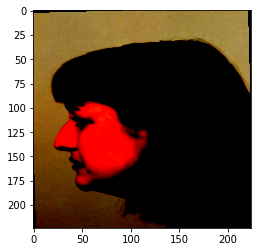

In [109]:
for datas,label in train_dataLoader:
  plt.imshow(datas[0].view(-1,224,224).detach().numpy().transpose(1, 2, 0))
  break

In [110]:
test_dataLoader=data.DataLoader(test_dataset,batch_size=10,shuffle=False)

# model ダウンロード

In [111]:
#学習済みモデルVGG16をロード

#VGG-16モデルのインスタンスを生成
use_pretrained=True
net=models.vgg16_bn(pretrained=False)
net.load_state_dict(torch.load("modelParam/vgg16_bn-6c64b313.pth"))


"""
net=models.resnet18(pretrained=False)
net.load_state_dict(torch.load('modelParam/resnet18-f37072fd.pth'))
"""

FileNotFoundError: ignored

In [112]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
#モデル追加
save_path='weight_fine_tuning.pth'
net.classifier.add_module("7",nn.Linear(in_features=1000,out_features=7))
if os.path.exists(save_path):
  net.load_state_dict(torch.load(save_path))
net.train()
#net.add_module("last_fc",nn.Linear(1000,101,bias=False))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
for name,_ in net.named_parameters():
  print(name)

features.0.weight
features.0.bias
features.1.weight
features.1.bias
features.3.weight
features.3.bias
features.4.weight
features.4.bias
features.7.weight
features.7.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
features.11.weight
features.11.bias
features.14.weight
features.14.bias
features.15.weight
features.15.bias
features.17.weight
features.17.bias
features.18.weight
features.18.bias
features.20.weight
features.20.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.25.weight
features.25.bias
features.27.weight
features.27.bias
features.28.weight
features.28.bias
features.30.weight
features.30.bias
features.31.weight
features.31.bias
features.34.weight
features.34.bias
features.35.weight
features.35.bias
features.37.weight
features.37.bias
features.38.weight
features.38.bias
features.40.weight
features.40.bias
features.41.weight
features.41.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


# 損失関数と最適化手法

In [ ]:
criterion=nn.CrossEntropyLoss()

In [ ]:
for i in net.parameters():
  print(i.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:

params_to_update_1=[]
params_to_update_2=[]
params_to_update_3=[]
updata_param_names_1=["features"]
updata_param_names_2=["classifier.0.weight","classifier.0.bias","classifier.3.weight","classifier.3.bias","classifier.6.weight","classifier.6.bias"]
updata_param_names_3=["classifier.7.weight","classifier.7.bias"]
for name,param in net.named_parameters():
  if updata_param_names_1[0] in name:
    param.requires_grad=True
    params_to_update_1.append(param)
    print("params_to_update_１に格納：",name)
  elif name in updata_param_names_2:
    param.requires_grad=True
    params_to_update_2.append(param)
    print("param_to_update_2に格納：",name)
  elif name in updata_param_names_3:
    param.requires_grad=True
    params_to_update_3.append(param)
    print("param_to_update_3に格納:",name)
  else:
    param.requires_grad=False
    print("勾配計算なし。学習しない雑魚：",name)
  

params_to_update_１に格納： features.0.weight
params_to_update_１に格納： features.0.bias
params_to_update_１に格納： features.1.weight
params_to_update_１に格納： features.1.bias
params_to_update_１に格納： features.3.weight
params_to_update_１に格納： features.3.bias
params_to_update_１に格納： features.4.weight
params_to_update_１に格納： features.4.bias
params_to_update_１に格納： features.7.weight
params_to_update_１に格納： features.7.bias
params_to_update_１に格納： features.8.weight
params_to_update_１に格納： features.8.bias
params_to_update_１に格納： features.10.weight
params_to_update_１に格納： features.10.bias
params_to_update_１に格納： features.11.weight
params_to_update_１に格納： features.11.bias
params_to_update_１に格納： features.14.weight
params_to_update_１に格納： features.14.bias
params_to_update_１に格納： features.15.weight
params_to_update_１に格納： features.15.bias
params_to_update_１に格納： features.17.weight
params_to_update_１に格納： features.17.bias
params_to_update_１に格納： features.18.weight
params_to_update_１に格納： features.18.bias
params_to_update_１に格納： featu

In [ ]:
#このようにして配列に挿入した辞書函数使って、モデルパラメータごとにオプティマイザーのパラメーターを設定することができる
optimizer=optim.Adam([{'params':params_to_update_1,'lr':1e-4},
                      {'params':params_to_update_2,'lr':5e-4},
                      {'params':params_to_update_3,'lr':1e-3}])
#optimizer=optim.Adam(net.parameters(),lr=0.001)

In [ ]:
def tarin_model(net,dataloaders_dict,criterion,optimizer,num_epochs):
  #初期設定
  #GPUが使えるかを確認する
  device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print('使用でヴァイス:',device)
  #ネットワークをGPUへ
  net=net.to(device)
  #ネットワークがある程度固定(epochごとにネットワーク構造や損失関数が変わったりしない)の場合に高速化させる
  torch.backends.cudnn.benchmark=True
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1,num_epochs))
    print('__________')
    for phase in ['train','test']:
      if phase=='train':
        net.train()
      else:
        net.eval()
      epoch_loss=0.0
      epoch_corrects=0
      for inputs,labels in tqdm(data_loaders_dict[phase]):
        #入力をGPUへ
        inputs=inputs.to(device)
        labels=labels.to(device)
        #optimizerの初期化
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
          outputs=net(inputs)
          #print("output",outputs.shape)
          #print("labels",torch.max(labels,1)[1])
          loss=criterion(outputs,labels)
          _,preds=torch.max(outputs,1)
          if phase=='train':
            loss.backward()
            optimizer.step()
          #tensor.item()はTensor内部の数値をPythonの数字で出力.戻り値はintやfloat
          epoch_loss+=loss.item()*inputs.size(0)
          #Tensor.dataはTensorのコピーを作成する。戻り値もTensor
          epoch_corrects+=torch.sum(preds==labels.data)
      epoch_loss=epoch_loss/len(data_loaders_dict[phase].dataset)
      epoch_acc=epoch_corrects.double()/len(data_loaders_dict[phase].dataset)
      net=net.to("cpu")
      torch.save(net.state_dict(),save_path)
      net=net.to(device)
      print('{} Loss: {:4f} Acc: {:4f}'.format(phase,epoch_loss,epoch_acc))

In [ ]:
data_loaders_dict={"train":train_dataLoader,"test":test_dataLoader}

In [ ]:
num=2
tarin_model(net,data_loaders_dict,criterion,optimizer,num_epochs=num)

使用でヴァイス: cuda
Epoch 1/2
__________


  0%|                                                                                         | 0/7575 [00:00<?, ?it/s]E:\Anaconda\envs\AIProj\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  4%|██▊                                                                          | 280/7575 [03:56<1:23:35,  1.45it/s]

In [ ]:
dat